# Computational Aspects of Machine Learning - By Waleed Bin Khalid

This experiment is in conjunction with the paper submitted for the seminar **Computational Aspects of Machine Learning** at the Technical University of Munich. We compare the some numerical optimizers with respect to their accuracy and time complexity with the help of a simple example. We train a convolutional neural network to classify the well-known MNIST dataset which consists of 60,000 $28 \times 28$ pixel images of hand drawn numbers. We keep all the parameters of our neural network the same except for the Numerical Optimizer utilized to train the network and observe the empirical results.

Source: This experiment was taken from https://nextjournal.com/gkoehler/pytorch-mnist and edited to suit experimentation needs.

### We analyze the following Numerical Optimizers in this experiment with the aid of the well known MNIST dataset.
1. SGD
2. SGD with Momentum
3. Nesterov Momentum
4. Adagrad
5. ADAM
6. LBFGS
8. Hessian Free
9. Newton-CG

## Importing required libraries

In [12]:
import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt
import timeit
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from network import Net

## Setting general hyperparameters

Throughout these experiments we work with the following hyperparameters. In somecases certain parameters are varied which are mentioned in the respective sections where the effect of the change of this parameter is discussed.

In [13]:
h_params = {'n_epochs' : 3,
'batch_size_train' : 64,
'batch_size_test' : 1000,
'learning_rate' : 0.01,
'momentum' : 0.9,
'log_interval' : 10,
'random_seed' : 1
}

# GPU is not available :(
torch.backends.cudnn.enabled = False
torch.manual_seed(h_params['random_seed'])

### Downloading the MNIST Dataset

We classify the well-known MNIST dataset which consists of 60,000, $28 \times 28$ pixel images of hand drawn numbers. We keep all the parameters of our neural network the same except for the Numerical Optimizer utilized to train the network and observe the empirical results. 

In [14]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=h_params['batch_size_train'], shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=h_params['batch_size_test'], shuffle=True)

c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Outlook on the Dataset
The data is a set of 60,000 28x28 pixel images with corresponding ground truth labels.

In [15]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

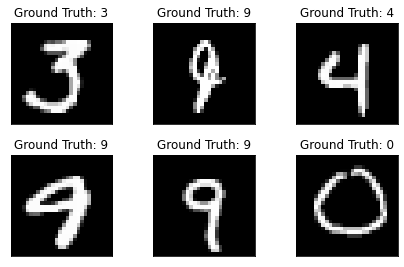

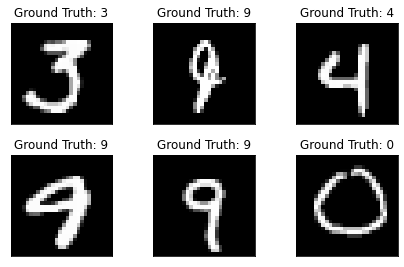

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### The Network
The `train` and `test` functions will be used to train the networks with different optimizers and will subsequently fill arrays that contain the data regarding the training and test loss. This will later be plotted for comparision. We will also store the time information.

Our network starts with two convolution layers of kernel size 5 each followed by two fully connected layers of size 50 and 10. The final fully connected layers has 10 outputs which map to the 10 classes available in the MNIST dataset. We also incorporate dropout and use ReLU as our activation function throughout the experiment.

We use the cross-entropy loss since we have a non-binary classification problem at our hands. 

In [17]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % h_params['log_interval'] == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [18]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

### Pre training
Before starting we show that the untrained network predicts each class with roughly the same weight. Hence we have an accuracy of ~ 10% as we have 10 classes and each class has an equal chance of getting selected by the untrained network. We can also see this visually as most of the labels are wrong.

F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Computational Aspects of Machine Learning\code\network.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)



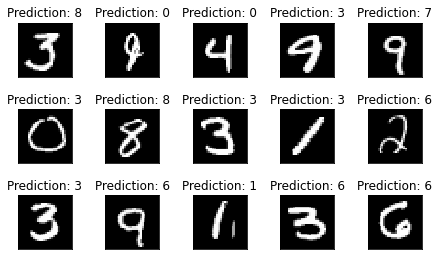

In [19]:
network = Net()

with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]


test()

## SGD
The first method we have is the stochastic gradient descent without momentum. We take independent identically distributed samples of data based on a batch size for each update. The batch size becomes another hyperparameter that we must care for during optimization.

$$\theta_{t+1}=\theta_{t}-\alpha \cdot \nabla_{\theta_t} J(\theta_{t+1}, x^{i:i+n}, y^{i:i+n})
$$

In [20]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=0)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd = toc - tic

train_losses_sgd = train_losses.copy()
train_counter_sgd = train_counter.copy()
test_losses_sgd = test_losses.copy()
test_counter_sgd = test_counter.copy()


Test set: Avg. loss: 2.3101, Accuracy: 722/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294282
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.278432
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.335654
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.302568
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.275327
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.304407
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.299929
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.270725
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.266293
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.227145
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.207008
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.277705
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.177691
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.237753
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.165231
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.221311
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.140858
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.099575
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.076228
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.397543
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.288520
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.488744
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.462848
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.375187
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.548208
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.329413
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.455938
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.650581
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.357832
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.574264
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.477592
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.354382
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.504646
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.336719
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.430336
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.223723
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.510011
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.475238
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.401527


### Visualization of SGD without Momentum

We visualize the training progress of the stochastic gradient method without the use of momentum and the resultant classification on some text images.

SGD Took 120.1526159 To Execute

Test set: Avg. loss: 0.1385, Accuracy: 9596/10000 (96%)



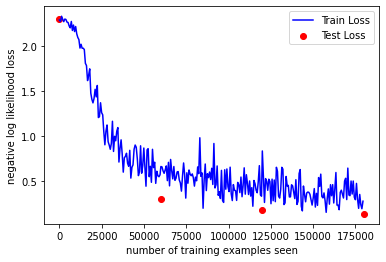

In [21]:
print("SGD Took", time_sgd, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd, train_losses_sgd, color='blue')
plt.scatter(test_counter_sgd, test_losses_sgd, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

# # fig

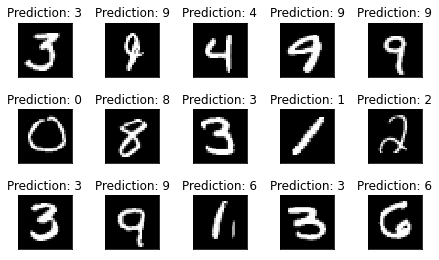

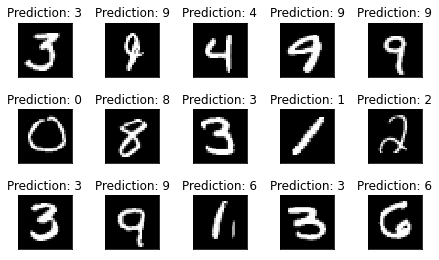

In [22]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## SGD With Momentum

SGD can be very erratic as we can have sharp steps in directions that do not produce any meaningful reduction in the loss in the learnable parameter space. By applying the concept of momentum, we want the previous updates of our trainable parameters to have an effect on the current learning step. The addition of momentum helps the SGD to step in relevant directions and dampens movement in directions that have too much variance. 
$$v_{t} = \beta v_{t-1} - \alpha \nabla_{\theta_t} J(\theta_{t}, x^{i:i+n}, y^{i:i+n})$$
$$\theta_{t+1} =\theta_{t} + v_{t}$$

In [23]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=h_params['momentum'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd_momentum = toc - tic

train_losses_sgd_momentum = train_losses.copy()
train_counter_sgd_momentum = train_counter.copy()
test_losses_sgd_momentum = test_losses.copy()
test_counter_sgd_momentum = test_counter.copy()


Test set: Avg. loss: 2.3079, Accuracy: 1102/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343184
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.289637
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.195188
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.910522
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.245062
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.607836
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.851366
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.130416
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.977893
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.838684
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.727980
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.573035
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.782897
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.639212
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.904929
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.729798
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.621734
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.481975
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.677297
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.127645
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.285143
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.229999
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.172660
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.176373
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.216365
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.174766
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.273017
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.118085
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.237560
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.517034
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.301584
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.257639
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.168192
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.319382
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.217111
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.261611
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.125264
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.431465
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.157801


### Visualization of SGD with Momentum

We visualize the training progress of the stochastic gradient method with the use of momentum and the resultant classification on some text images.

SGD With Momentum Took 120.1526159 To Execute

Test set: Avg. loss: 0.0521, Accuracy: 9842/10000 (98%)



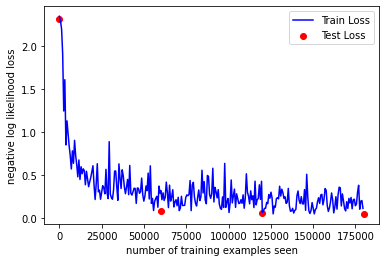

In [24]:
print("SGD With Momentum Took", time_sgd, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, color='blue')
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

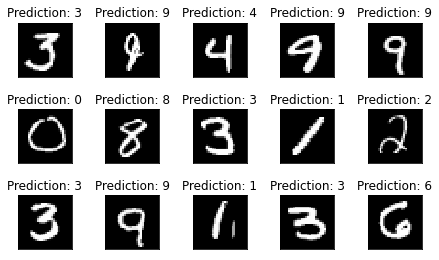

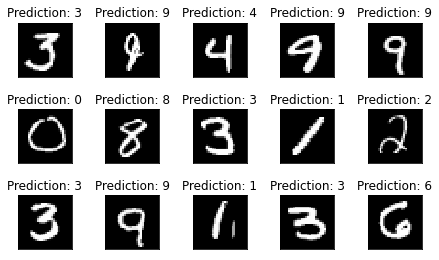

In [25]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Nesterov Momentum

We can also utilize the gradient of a future position for our update step instead of using the gradient at the current time step. For this reason, the Nestrov Momentum, or the look ahead momentum can be incorporated.

$$\theta^*_{t} = \theta_t + \beta v_{t-1} $$
$$v_{t} =\beta v_{t-1} - \alpha \nabla_{\theta_t} J(\theta^*_{t}, x^{i:i+n}, y^{i:i+n}) $$
$$\theta_{t+1} =\theta_{t} + v_{t}$$

In [26]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=h_params['momentum'], nesterov=True)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd_nestrov = toc - tic

train_losses_sgd_nestrov = train_losses.copy()
train_counter_sgd_nestrov = train_counter.copy()
test_losses_sgd_nestrov = test_losses.copy()
test_counter_sgd_nestrov = test_counter.copy()


Test set: Avg. loss: 2.3119, Accuracy: 745/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323633
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.281059
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.212948
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.104768
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.746699
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.534265
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.920177
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.170454
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.861764
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.873513
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.722510
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.916100
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.753711
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.888757
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.671680
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.701979
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.442160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.671520
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.697184
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.196957
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.308677
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.116582
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.476631
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.263017
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.627232
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.343836
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.413900
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.193950
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.415846
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.166029
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.207096
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.252870
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.263139
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.247666
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.402015
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.213706
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.156394
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.119454
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.100547


### Visualization for Neterov Momentum

We visualize the training progress of the Neterov Momentum method and the resultant classification on some text images.

Nestrov Took 120.1526159 To Execute

Test set: Avg. loss: 0.0581, Accuracy: 9814/10000 (98%)



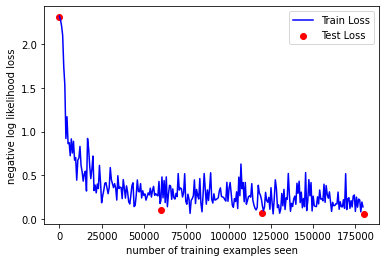

In [27]:
print("Nestrov Took", time_sgd, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd_nestrov, train_losses_sgd_nestrov, color='blue')
plt.scatter(test_counter_sgd_nestrov, test_losses_sgd_nestrov, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

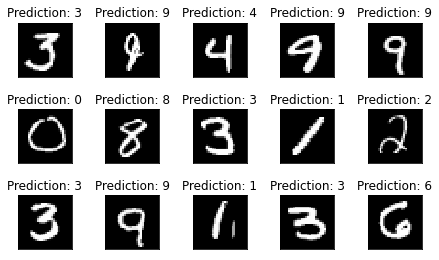

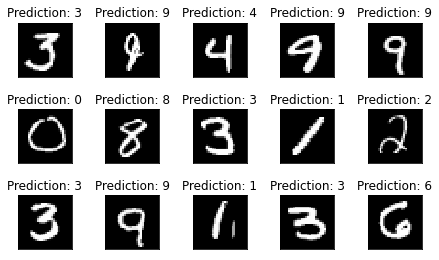

In [28]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

### Comparision of SGD, SGD Momentum and Nestrov


We can see that SGD without momentum gets stuck at a worse local minimum compared to the momentum methods. We also see a steeper fall for both the momentum methods which signifies that we have significantly improved the learning speed of our neural network.

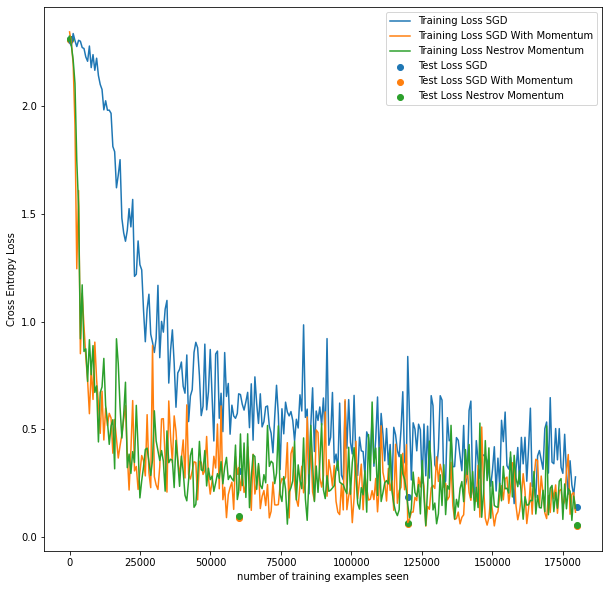

In [29]:
fig = plt.figure(figsize = (10,10))
plt.plot(train_counter_sgd, train_losses_sgd, label = "Training Loss SGD")
plt.scatter(test_counter_sgd, test_losses_sgd, label = "Test Loss SGD")
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, label = "Training Loss SGD With Momentum")
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, label = "Test Loss SGD With Momentum")
plt.plot(train_counter_sgd_nestrov, train_losses_sgd_nestrov, label = "Training Loss Nestrov Momentum")
plt.scatter(test_counter_sgd_nestrov, test_losses_sgd_nestrov, label = "Test Loss Nestrov Momentum")

plt.legend(loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Cross Entropy Loss')
plt.show()
# # fig
# test_losses_sgd_nestrov

In [30]:
fig.savefig("momentum_optimizer_comparision.pdf", bbox_inches='tight')

### ADAGrad

ADAgrad uses the idea of weighing each learnable parameter with a different step size during the optimization step. The main advantage is that we do not need to tune the learning rate $\alpha$ and implementations use a default value of 0.01 as the accumulated gradient information adjusts the step-size for us. This is significant since hyper parameter tuning is a time consuming process and the learning rate is one of the most crucial hyper parameters that is often extremely difficult to tune properly. 

$$\nu_{t}=\beta_{1} \nu_{t-1}+\left(1-\beta_{1}\right) g_{t}$$
$$V_{t}=\beta_{2} V_{t-1}+\left(1-\beta_{2}\right)\left(g_{t}\right)^{2}$$
$$\theta_{t+1}=m_{t}-\alpha \frac{\nu_{t}}{\sqrt{V_{t}}+\epsilon}$$

In [31]:
network = Net()
optimizer = optim.Adagrad(network.parameters(), lr=h_params['learning_rate'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
train_losses_adagrad = train_losses.copy()
test_losses_adagrad = test_losses.copy()
train_counter_adagrad = train_counter.copy()
test_counter_adagrad = test_counter.copy()

F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Computational Aspects of Machine Learning\code\network.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3076, Accuracy: 878/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295124
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.918970
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.387364
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.995868
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.844952
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.837228
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.955933
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.712172
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.642848
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.698892
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.759072
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.799328
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.601874
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.703871
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.573288
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.595664
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.611778
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.406993
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.364519
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.173976
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.229928
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.201577
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.315183
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.156407
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.347628
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.276916
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.331428
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.202121
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.260829
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.419167
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.183838
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.524636
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.127961
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.380855
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.258845
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.434157
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.346208
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.178159
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.167391


### Visualizing results from ADAGrad

Text(0, 0.5, 'negative log likelihood loss')

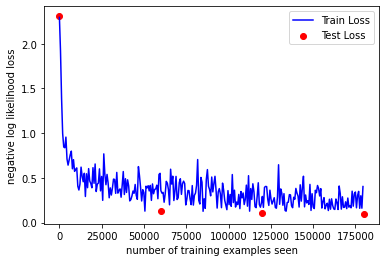

In [32]:
fig = plt.figure()
plt.plot(train_counter_adagrad, train_losses_adagrad, color='blue')
plt.scatter(test_counter_adagrad, test_losses_adagrad, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# # fig

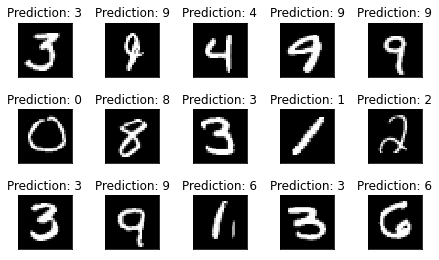

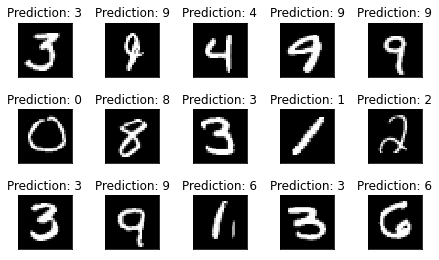

In [33]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## ADAM

The ADAM method uses the best of both worlds to combine the momentum methods and the adaptive learning rate methods to give what is now the staple numerical optimzer in most deep learning projects. The method stores both the exponentially decaying average of past gradients sqsuares i.e. the second momentum, along with the exponentially decaying average of past gradients i.e. first momentums.

$$\nu_{t}=\beta_{1} \nu_{t-1}+\left(1-\beta_{1}\right) g_{t} $$
$$V_{t}=\beta_{2} V_{t-1}+\left(1-\beta_{2}\right)\left(g_{t}\right)^{2} $$
$$\hat{\nu_{t}}=\frac{\nu_{t}}{1-\beta_1}$$
$$\hat{V_{t}} = \frac{V_{t}}{1-\beta_2}$$
$$\theta_{t+1}=\theta_{t}-\alpha \frac{\hat{\nu_{t}}}{\sqrt{\hat{V_{t}}}+\epsilon}$$

In [34]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=h_params['learning_rate'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
train_losses_adam = train_losses.copy()
train_counter_adam = train_counter.copy()
test_losses_adam = test_losses.copy()
test_counter_adam = test_counter.copy()


Test set: Avg. loss: 2.3061, Accuracy: 1400/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319356
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.041607
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.788545
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.628889
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.078979
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.067006
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.049500
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.716097
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.988971
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.815768
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.884441
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.747705
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.702612
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.790914
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.362467
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.429121
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.717769
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.460954
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.753284
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.459649
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.420513
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.310654
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.504396
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.673129
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.535395
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.598764
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.396786
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.375616
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.405312
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.383344
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.520601
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.437075
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.636651
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.643533
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.430382
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.114687
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.561734
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.581286
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.488917


### Visualizing the results form the ADAM Method

Text(0, 0.5, 'negative log likelihood loss')

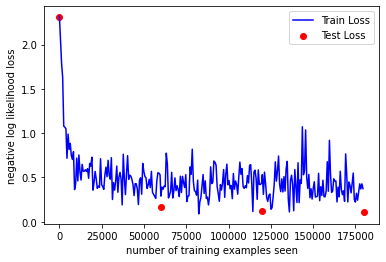

In [35]:
fig = plt.figure()
plt.plot(train_counter_adam, train_losses_adam, color='blue')
plt.scatter(test_counter_adam, test_losses_adam, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# # fig

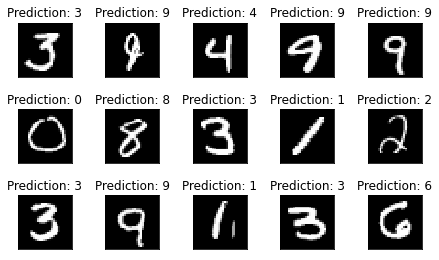

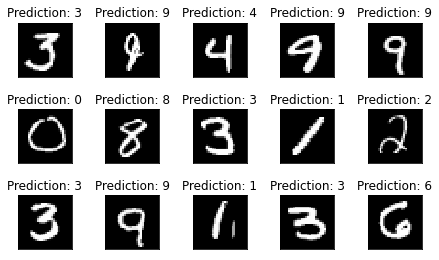

In [36]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## The non-convergence of Adaptive Methods

The ADAM method suffers from an important disadvantage as well in that, the method often does not converge. We can observe this by comparing it to SGD with momentum.

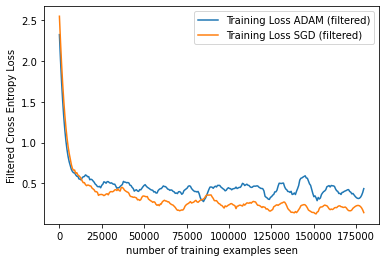

In [37]:
from scipy.signal import savgol_filter
fig, ax = plt.subplots()
box_pts=6
# box = np.ones(box_pts)/box_pts
adam_loss_moving_avg = savgol_filter(train_losses_adam, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
ax.plot(train_counter_adam, adam_loss_moving_avg, label = 'Training Loss ADAM (filtered)')
# adagrad_loss_moving_avg = savgol_filter(train_losses_adagrad, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
# ax.plot(train_counter_adagrad, adagrad_loss_moving_avg, label = 'Training Loss ADAGrad (filtered)')
sgdm_loss_moving_avg = savgol_filter(train_losses_sgd_momentum, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
ax.plot(train_counter_sgd_momentum, sgdm_loss_moving_avg, label = 'Training Loss SGD (filtered)')
plt.legend()
plt.xlabel('number of training examples seen')
plt.ylabel('Filtered Cross Entropy Loss')
fig.savefig('figures/adam_vs_sgdm.pdf')

### ADAM vs ADAgrad vs SGD Momentum

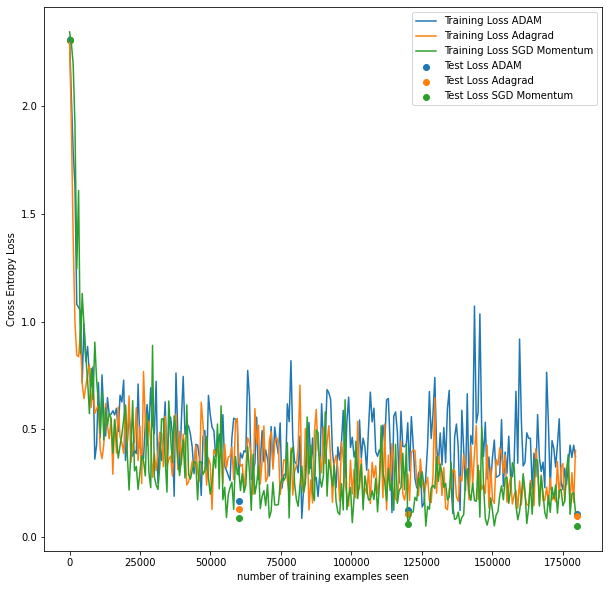

In [38]:
fig = plt.figure(figsize = (10,10))
plt.plot(train_counter_adam, train_losses_adam, label = "Training Loss ADAM")
plt.scatter(test_counter_adam, test_losses_adam, label = "Test Loss ADAM")
plt.plot(train_counter_adagrad, train_losses_adagrad, label = "Training Loss Adagrad")
plt.scatter(test_counter_adagrad, test_losses_adagrad, label = "Test Loss Adagrad")
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, label = "Training Loss SGD Momentum")
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, label = "Test Loss SGD Momentum")

plt.legend(loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Cross Entropy Loss')
plt.show()
# # fig
# test_losses_sgd_nestrov

### LBFGS

We refer to the taylors expansion

$$J(\theta) \approx J(\theta_t)+\nabla J(\theta)^{\top} (\theta - \theta_t)+\frac{1}{2} (\theta - \theta_t)^{\top} \mathrm{H(\theta)} (\theta - \theta_t)$$

and approximate $H(\theta_t)$ with $H^{*}(\theta_t)$. The BFGS method stems from the Broyden's method where we iteratively build our matrix by minimizing the frobenius norm of $H^*_{t+1} - H^*_{t}$. We then make a minimal adjustment such that our matrix remains symmetric and positive definite. 

The BFGS method cannot be used to solve large scale problems due to the intense memory footprint that comes with generating a sequence of large matrices for high dimensional problems such as deep neural networks. The answer to this memory problem is the limited or L-BFGS method. The big difference is that we now only store a subset of the entire matrix by storing a few vectors out of the entire matrix. It is important to note that stochastic batches do not work well because it needs gradients of high quality in order to construct useful quadratic models and perform reliable line searches.

In [39]:
network = Net()
# lr need not be set
optimizer = optim.LBFGS(network.parameters(), lr=1)

train_losses = []
test_losses = []
train_counter_lbfgs = []
test_counter_lbfgs = [0,1,2,3,4,5,6]

train_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2500, shuffle=True)

test_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2500, shuffle=True)

def train_lbfgs():
    network.train()
    def closure():
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        return loss
    for epoch, (data, target) in enumerate(train_loader_second_order):
        if epoch <= 6:
            test()
            loss = optimizer.step(closure)
            train_losses.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_second_order.dataset),
                100. * batch_idx / len(train_loader_second_order), loss.item()))
            train_counter_lbfgs.append(epoch)
        else:
            break

    
tic = timeit.default_timer()
train_lbfgs()
toc = timeit.default_timer()

time_lbfgs = toc-tic

train_losses_lbfgs = train_losses.copy()
test_losses_lbfgs = test_losses.copy()


F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Computational Aspects of Machine Learning\code\network.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3040, Accuracy: 974/10000 (10%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301037

Test set: Avg. loss: 0.6723, Accuracy: 8030/10000 (80%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.786323

Test set: Avg. loss: 0.3042, Accuracy: 9128/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.311423

Test set: Avg. loss: 0.1539, Accuracy: 9593/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.208240

Test set: Avg. loss: 0.1828, Accuracy: 9638/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.182355

Test set: Avg. loss: 0.3555, Accuracy: 9708/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.459931

Test set: Avg. loss: 0.3941, Accuracy: 9679/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.517160


### Visualizing results of the L-BFGS method

Text(0, 0.5, 'negative log likelihood loss')

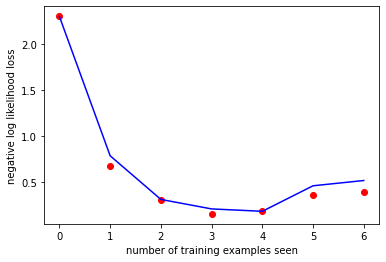

In [40]:
fig = plt.figure()
plt.plot(train_counter_lbfgs, train_losses_lbfgs, color='blue')
plt.scatter(test_counter_lbfgs, test_losses_lbfgs, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

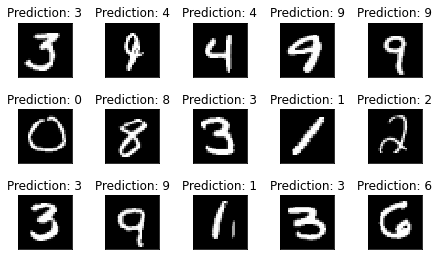

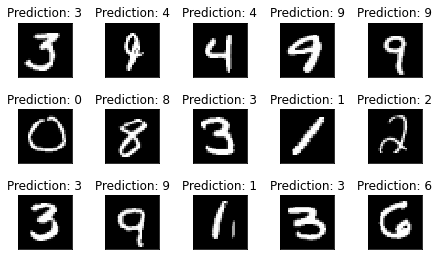

In [41]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Hessian Free

The Hessian Free method is very similar to the quasi Newton's method in that it uses local quadratic approximations for updates. However, unlike the previously discussed second order methods, if does not require any matrix inverse but rather uses the linear conjugate gradient method eliminating the need for the Hessian matrix.

Source: Optimization Code has been taken from https://github.com/moonl1ght/HessianFreeOptimization

In [42]:
from hf import HessianFree
network = Net()
# lr need not be set
optimizer = HessianFree(network.parameters())

train_losses = []
test_losses = []
train_counter_hf = []
test_counter_hf = [0,1,2,3,4,5,6]

train_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

test_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=500, shuffle=True)

def train_hf():
    network.train()
    def closure():
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward(retain_graph=True)
        return loss, output
#     for epoch in range(5):
    for epoch, (data, target) in enumerate(train_loader_second_order):
        if epoch <= 6:
            test()
            loss = optimizer.step(closure)
            train_losses.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_second_order.dataset),
                100. * batch_idx / len(train_loader_second_order), loss.item()))
            train_counter_hf.append(epoch)
        else:
            break
                

tic = timeit.default_timer()
train_hf()
toc = timeit.default_timer()

time_hf = toc-tic
train_losses_hf = train_losses.copy()
test_losses_hf = test_losses.copy()


Test set: Avg. loss: 2.3210, Accuracy: 416/10000 (4%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.148158

Test set: Avg. loss: 2.1566, Accuracy: 2617/10000 (26%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.976430

Test set: Avg. loss: 1.9806, Accuracy: 3770/10000 (38%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.876129

Test set: Avg. loss: 1.8901, Accuracy: 2461/10000 (25%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.883410

Test set: Avg. loss: 0.8904, Accuracy: 7388/10000 (74%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.510776

Test set: Avg. loss: 0.4890, Accuracy: 8777/10000 (88%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.305789

Test set: Avg. loss: 0.3160, Accuracy: 9275/10000 (93%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.178413


### Visualizing results of the Hessian Free method

Text(0, 0.5, 'negative log likelihood loss')

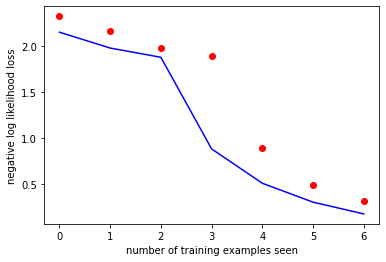

In [43]:
fig = plt.figure()
plt.plot(train_counter_hf, train_losses_hf, color='blue')
plt.scatter(test_counter_hf, test_losses_hf, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


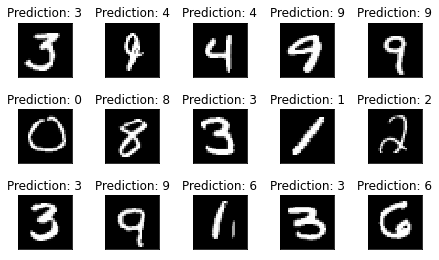

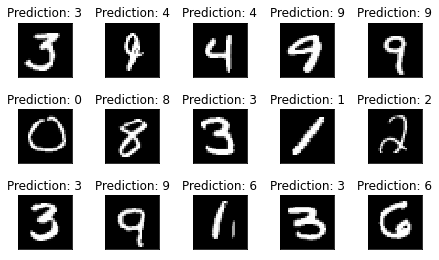

In [44]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

### Comparing L-BFGS with Hessian Free method

We observe that both methods require a very small number of very expensive iterations but the LBFGS method has a sharper fall which then settles at a more or less constant loss value.

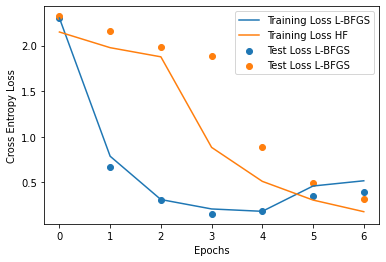

In [45]:
fig = plt.figure()
plt.plot(train_counter_lbfgs, train_losses_lbfgs, label = 'Training Loss L-BFGS')
plt.scatter(test_counter_lbfgs, test_losses_lbfgs, label = 'Test Loss L-BFGS')
plt.plot(train_counter_hf, train_losses_hf, label = 'Training Loss HF')
plt.scatter(test_counter_hf, test_losses_hf, label = 'Test Loss L-BFGS')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.savefig("lbfgs_hf.pdf")

### Comparing time complexity of various first and second order methods

As expected we see that even though the second order methods have very few iteration counts, they require more time than the first order methods which have iteration counts that are orders of magnitude higher. This illustrates why the second order method despite their mathematical speed are not utilized too often in practical deep learning tasks.

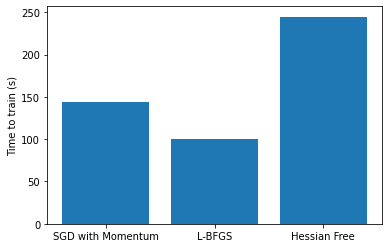

In [46]:
fig = plt.figure()
plt.bar(["SGD with Momentum", "L-BFGS", "Hessian Free"], [time_sgd_momentum, time_lbfgs, time_hf])
plt.ylabel("Time to train (s)")
fig.savefig("execution_time.pdf")